# Google Play Store Twitter Sentiment Analysis
Data provided by [Kaggle](https://www.kaggle.com/lava18/google-play-store-apps). In addition Twitter will be analyzed for any further data on the app itself.

A coulple questions come to mind:
1. Is there really a corelation between the number of times an app was downloaded and the Twitter sentiment.
2. Try to find from the top 10000 apps (based on installs) how each install correlates to the positve and negative sentiments on Twitter.
3. Try to find which genre of apps brings the most positive and negative sentiment out of the top 10 downloads from the play store.


For the purpose of the second task **Syuzhet** will be used. **Syuzhet** get's the sentiment into 10 emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, trust, negative and positive.
The notebook will examine only the positive and negative sentiments for each first 100 tweets for each app.

But first let's start with loading the libraries:

In [30]:
library(ggplot2)
library(Amelia)
library(dplyr)
library(rjson)
library(twitteR)
library(syuzhet)

set.seed(42)

## 1. Loading and preprocessing the data.

### 1.1 Loading the dataset.

In [2]:
df <- data.frame(read.csv('data/googleplaystore.csv'))

In [3]:
# Displaying the head
head(df)

App,Category,Rating,Reviews,Size,Installs,Type,Price,Content.Rating,Genres,Last.Updated,Current.Ver,Android.Ver
Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up


### 1.2 Configuring the twitter connection

In [4]:
twitterCreds <- fromJSON(file = "data/twitter_access.json")

In [5]:
setup_twitter_oauth(twitterCreds$consumer_key, 
                    twitterCreds$consumer_secret, 
                    access_token=twitterCreds$access_token, 
                    access_secret=twitterCreds$access_token_secret)

[1] "Using direct authentication"


In [6]:
# code snippets to remind me how its done.
# soccer.tweets <- searchTwitter("soccer", n=2000, lang="en")
# soccer.tweets.df <- twListToDF(soccer.tweets)
# get_nrc_sentiment(soccer.tweets.df$text)

### 1.3 Getting the bearings of the datasets.
First - let's get the dimensions and structure of the dataset.

In [7]:
dim(df)

[1] 10841    13

In [8]:
str(df)

'data.frame':	10841 obs. of  13 variables:
 $ App           : Factor w/ 9660 levels "- Free Comics - Comic Apps",..: 7206 2551 8970 8089 7272 7103 8149 5568 4926 5806 ...
 $ Category      : Factor w/ 34 levels "1.9","ART_AND_DESIGN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Rating        : num  4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.1 4.4 4.7 ...
 $ Reviews       : Factor w/ 6002 levels "0","1","10","100",..: 1183 5924 5681 1947 5924 1310 1464 3385 816 485 ...
 $ Size          : Factor w/ 462 levels "1,000+","1.0M",..: 55 30 368 102 64 222 55 118 146 120 ...
 $ Installs      : Factor w/ 22 levels "0","0+","1,000,000,000+",..: 8 20 13 16 11 17 17 4 4 8 ...
 $ Type          : Factor w/ 4 levels "0","Free","NaN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price         : Factor w/ 93 levels "$0.99","$1.00",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Content.Rating: Factor w/ 7 levels "","Adults only 18+",..: 3 3 3 6 3 3 3 3 3 3 ...
 $ Genres        : Factor w/ 120 levels "Action","Action;Action & Adventure",..: 10 13 10 10 

**Structure summary**:  
From the structure it seems that some columns, that one would expect to be of type *numerical* are actually *categoricals*. The only one that would be true is *Reviews* as the column indicates the number of reviews an app is getting. In addition *Size* also could be translated to a numerical value as there are 462 levels. On the other hand it seems that the column *Installs* is aggregated in 22 levels and is indeed a categorical value. Same goes for the *Price* with 93 levels. The *Last.Updated* column seems like a date-time.  

#### 1.3.1 Cleaning potential errors.

But first let's clean the dataset of any potential errors - what does this mean - we need to check each column if there is a value(s) that is out of context for the column. Let's make a small plan with each of the columns.

1. App - nothing to do here as names can vary quite a lot.
2. Category - as there aren't many factors we can get the unique values and check if something is out of context.
3. Rating - nothing to do here as well, as the structure of the dataframe indicated it is a numerical - which we expect.
4. Reviews - check if the column in entirely composed of integers. A non-integer will indicate a problem with the data.
5. Size - looking at the head we can see that if the value begins with a number - it will indicate a valid value. Anything else we have to do per item basis.
6. Installs - again like the reviews - if the first digit is an integer its okay - else process it manually.
7. Type - only 4 factors, thus we can examine them one by one.
8. Price - again a simple check - the first char should be either a 0, an F (for Free) or a dollar sign.
9. Content.Rating - only 7 factors - again we can treat them case by case.
10. Genres - this is a tricky one as the case can be as the App column. We can leave it for now and see if outliers happen go back and fix them.
11. Last.Updated - try to convert to  a date - if it fails - examine it.
12. Curent.Ver & Android.Ver - leave as is, as they are not intended to be used.

##### *2. Category*

In [9]:
unique(df$Category)

[1] ART_AND_DESIGN      AUTO_AND_VEHICLES   BEAUTY             
 [4] BOOKS_AND_REFERENCE BUSINESS            COMICS             
 [7] COMMUNICATION       DATING              EDUCATION          
[10] ENTERTAINMENT       EVENTS              FINANCE            
[13] FOOD_AND_DRINK      HEALTH_AND_FITNESS  HOUSE_AND_HOME     
[16] LIBRARIES_AND_DEMO  LIFESTYLE           GAME               
[19] FAMILY              MEDICAL             SOCIAL             
[22] SHOPPING            PHOTOGRAPHY         SPORTS             
[25] TRAVEL_AND_LOCAL    TOOLS               PERSONALIZATION    
[28] PRODUCTIVITY        PARENTING           WEATHER            
[31] VIDEO_PLAYERS       NEWS_AND_MAGAZINES  MAPS_AND_NAVIGATION
[34] 1.9                
34 Levels: 1.9 ART_AND_DESIGN AUTO_AND_VEHICLES BEAUTY ... WEATHER

Right of the bat we encounter an error. - 1.9 should not be there. Since the data is a csv, this is likely caused by missing a comma. Let's try to find the number of these columns.

In [10]:
length(df[df$Category == 1.9,]$Category)

[1] 1

Just one row - we can drop it.

In [11]:
df = df[!(df$Category == 1.9),]

##### *4. Reviews*

In [12]:
# should give us an error if there is a value we need to take into an account
df$Reviews = as.numeric(as.character(df$Reviews))

Since the transform didn't give us any errors we may proceed to the next item.  
##### *5. Size*

In [13]:
# bad code a head
non_numeric_size <- c()
for (item in unique(df$Size)) {
    x = is.na(as.numeric(substr(as.character(item), 1, 1)))
    if(x) {
        non_numeric_size <- c(non_numeric_size, item)
    }
}

print(non_numeric_size)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

[1] "Varies with device"


So it seems that the only issue is with "Varies with device", which is a valid category.
##### *6.Installs*

In [14]:
z = as.numeric(as.character(df$Installs))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

It returned a warning, that some of the values cannot be effectively transformed to numeric ones. Since there are only 22 levels we can inspect them one by one.

In [15]:
unique(df$Installs)

[1] 10,000+        500,000+       5,000,000+     50,000,000+    100,000+      
 [6] 50,000+        1,000,000+     10,000,000+    5,000+         100,000,000+  
[11] 1,000,000,000+ 1,000+         500,000,000+   50+            100+          
[16] 500+           10+            1+             5+             0+            
[21] 0             
22 Levels: 0 0+ 1,000,000,000+ 1,000,000+ 1,000+ 1+ 10,000,000+ 10,000+ ... Free

It seems that the `+` sign after each level created the problem. But we see that the values are numeric. It is a categorical variable, grouped by multiples of 5/10, but it will serve more purpose as a numerical variable.

In [16]:
clean_plus <- function(val) {
    val_str <- as.character(val)
    if (nchar(val_str) == 1) {
        return(val)
    } else {
        return(as.numeric(gsub('\\,','', substr(val_str, 1, nchar(val_str) - 1))))
    }
}

In [17]:
df$Installs <- sapply(df$Install, clean_plus)

##### *7. Type*

In [18]:
unique(df$Type)

[1] Free Paid NaN 
Levels: 0 Free NaN Paid

The structure reported that we have 4 factors, but here there are only 3. Same with the *Installs* column - it seems that the row that was dropped in *Category* removed an unnesecary category.

##### 8. *Price*

In [19]:
irregular_items <- c()
for (item in unique(df$Price)) {
    if (!(substr(item,1,1) == '$' | substr(item,1,1) == '0')) {
        irregular_items <- c(irregular_items, item)
    }
}

print(irregular_items)

NULL


The check returned an empty list.

##### *9. Content.Rating*

In [20]:
unique(df$Content.Rating)

[1] Everyone        Teen            Everyone 10+    Mature 17+     
[5] Adults only 18+ Unrated        
Levels:  Adults only 18+ Everyone Everyone 10+ Mature 17+ Teen Unrated

This column seems right and no unexpected values came up.

##### *11 Last.Updated*

In [21]:
Sys.setlocale('LC_TIME', 'C') # To work with the format
df$Last.Updated <- as.Date(df$Last.Updated, format="%B %d, %Y")

[1] "C"

Let's verify the structure once more.

In [24]:
str(df)

'data.frame':	10840 obs. of  13 variables:
 $ App           : Factor w/ 9660 levels "- Free Comics - Comic Apps",..: 7206 2551 8970 8089 7272 7103 8149 5568 4926 5806 ...
 $ Category      : Factor w/ 34 levels "1.9","ART_AND_DESIGN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Rating        : num  4.1 3.9 4.7 4.5 4.3 4.4 3.8 4.1 4.4 4.7 ...
 $ Reviews       : num  159 967 87510 215644 967 ...
 $ Size          : Factor w/ 462 levels "1,000+","1.0M",..: 55 30 368 102 64 222 55 118 146 120 ...
 $ Installs      : num  1e+04 5e+05 5e+06 5e+07 1e+05 5e+04 5e+04 1e+06 1e+06 1e+04 ...
 $ Type          : Factor w/ 4 levels "0","Free","NaN",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Price         : Factor w/ 93 levels "$0.99","$1.00",..: 92 92 92 92 92 92 92 92 92 92 ...
 $ Content.Rating: Factor w/ 7 levels "","Adults only 18+",..: 3 3 3 6 3 3 3 3 3 3 ...
 $ Genres        : Factor w/ 120 levels "Action","Action;Action & Adventure",..: 10 13 10 10 12 10 10 10 10 12 ...
 $ Last.Updated  : Date, format: "2018-01-07" "2018-

All seems according to plan.

**Plan**:  
1. ~~*Preprocessing Data:*~~
    * ~~Check for outliers, as I saw some of the factors are unexpected, when taking into account the column's context.~~
    * ~~Finish transforming the other columns.~~
2. *Initial Dataviz:*  
    * Treat `Installs` as a target variable and get the relation between the Category, Rating, #Reviews, Type, Genres and Price.
    * Sort the dataset, based on Installs and start scraping Twitter.

#### 1.3.2 Initial Data Visiualization.
Let's treat the `Installs` as a target variable to explore the relationship between it and the other columns.

*-Category and Installs*

In [25]:
df.grp.cat <- aggregate(x = df$Installs, by=list(Category=df$Category), FUN=sum)
colnames(df.grp.cat) <- c('Category', 'Installs')

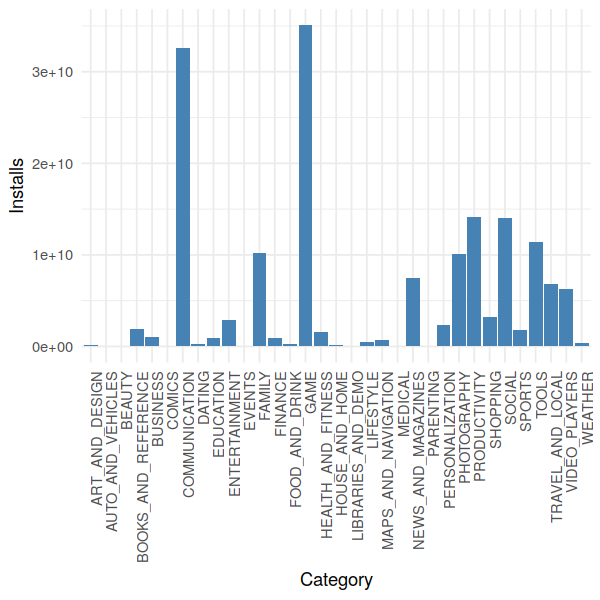

In [34]:
options(repr.plot.width=5, repr.plot.height=5)
pl <- ggplot(df.grp.cat, aes(Category, Installs)) + geom_bar(stat='identity', fill="steelblue") 
pl + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

It seems obvious that 'Communication' and 'Game' are the most popular categories, by far, on Google play.

*- Rating and Installs*

Warning message:
“Removed 1474 rows containing missing values (geom_point).”

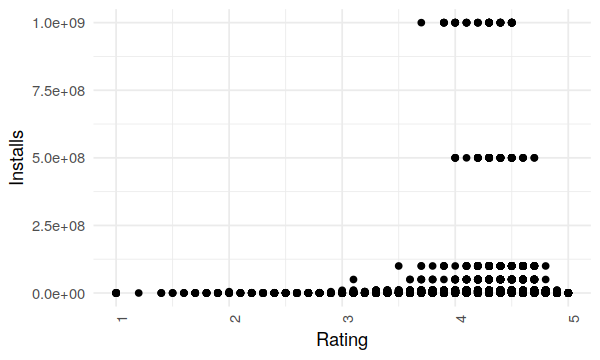

In [37]:
options(repr.plot.width=5, repr.plot.height=3)
pl <- ggplot(df, aes(Rating, Installs)) + geom_point()
pl + theme_minimal() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [51]:
min(df$Rating)

[1] NaN

In [48]:
df[is.na(df$Rating),]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content.Rating,Genres,Last.Updated,Current.Ver,Android.Ver
24,Mcqueen Coloring pages,ART_AND_DESIGN,NaN,61,7.0M,1e+05,Free,0,Everyone,Art & Design;Action & Adventure,2018-03-07,1.0.0,4.1 and up
114,Wrinkles and rejuvenation,BEAUTY,NaN,182,5.7M,1e+05,Free,0,Everyone 10+,Beauty,2017-09-20,8.0,3.0 and up
124,Manicure - nail design,BEAUTY,NaN,119,3.7M,5e+04,Free,0,Everyone,Beauty,2018-07-23,1.3,4.1 and up
127,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4M,1e+05,Free,0,Teen,Beauty,2018-07-17,1.15,4.1 and up
130,"Secrets of beauty, youth and health",BEAUTY,NaN,77,2.9M,1e+04,Free,0,Mature 17+,Beauty,2017-08-08,2.0,2.3 and up
131,Recipes and tips for losing weight,BEAUTY,NaN,35,3.1M,1e+04,Free,0,Everyone 10+,Beauty,2017-12-11,2.0,3.0 and up
135,"Lady adviser (beauty, health)",BEAUTY,NaN,30,9.9M,1e+04,Free,0,Mature 17+,Beauty,2018-01-24,3.0,3.0 and up
164,Anonymous caller detection,BOOKS_AND_REFERENCE,NaN,161,2.7M,1e+04,Free,0,Everyone,Books & Reference,2018-07-13,1.0,2.3 and up
181,SH-02J Owner's Manual (Android 8.0),BOOKS_AND_REFERENCE,NaN,2,7.2M,5e+04,Free,0,Everyone,Books & Reference,2018-06-15,3.0,6.0 and up
186,URBANO V 02 instruction manual,BOOKS_AND_REFERENCE,NaN,114,7.3M,1e+05,Free,0,Everyone,Books & Reference,2015-08-07,1.1,5.1 and up
